In [18]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy
import ipywidgets as widgets  # interactive display


In [19]:
# @title Figure settings
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 11
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [20]:
# @title Data retrieval

url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
  RequestAPI = requests.get(url)
except requests.ConnectionError:
  print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
  if RequestAPI.status_code != requests.codes.ok:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
  else:
    with open("data01_direction4priors.csv", "wb") as fid:
      fid.write(RequestAPI.content)


In [21]:
data = pd.read_csv("data01_direction4priors.csv")
data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1


In [22]:
# Calculate estimated degree in a new field with this name
# estimated_degree = np.degrees(np.arctan2(data['estimate_x'], data['estimate']))
data['estimated_degree'] = (np.degrees(np.arctan2(data['estimate_x'], data['estimate_y'])) + 360) % 360
print(data['estimated_degree'].head())


0    224.416887
1    226.708718
2    218.687309
3    219.833224
4    220.979140
Name: estimated_degree, dtype: float64


In [6]:
# @title sandbox

# prompt: how many distinct subject we have

@widgets.interact(number=widgets.IntSlider(min=1, max=3, step=1, value=1))
def hello(number):
  print(f"hello {number}")


num_distinct_subjects = data['subject_id'].nunique()
print(f"Number of distinct subjects: {num_distinct_subjects}")

num_distinct_sessions = data['session_id'].nunique()
print(f"Number of distinct sessions: {num_distinct_sessions}")

interactive(children=(IntSlider(value=1, description='number', max=3, min=1), Output()), _dom_classes=('widget…

Number of distinct subjects: 12
Number of distinct sessions: 9


In [17]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

# Widget for choosing subject
subject_options = sorted(data['subject_id'].unique())
@widgets.interact(subject=widgets.Dropdown(options=subject_options, description='Subject:'))
def plot_histograms(subject):
    # Filter data for selected subject
    subj_data = data[data['subject_id'] == subject]
    # Get unique prior_std and motion_coherence values
    prior_stds = sorted(subj_data['prior_std'].dropna().unique())
    motion_coherences = sorted(subj_data['motion_coherence'].dropna().unique())
    
    n_rows = len(prior_stds)
    n_cols = len(motion_coherences)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]
    
    for i, prior_std in enumerate(prior_stds):
        for j, motion_coh in enumerate(motion_coherences):
            ax = axes[i, j]
            # Filter for this prior_std and motion_coherence
            filt = (subj_data['prior_std'] == prior_std) & (subj_data['motion_coherence'] == motion_coh)
            trials = subj_data[filt]
            # Get true direction and estimated degree, drop NaN
            true_dir = trials['motion_direction'].dropna()
            est_deg = trials['estimated_degree'].dropna()
            # Plot histograms
            # print(trials.shape)
            bins = np.linspace(0, 360, 37)  # 10 degree bins
            ax.hist(true_dir % 360, bins=bins, alpha=0.6, label='True Direction', color='tab:blue')
            ax.hist(est_deg % 360, bins=bins, alpha=0.6, label='Estimated Degree', color='tab:orange')
            ax.set_title(f'Prior std: {prior_std}, Coh: {motion_coh}')
            ax.set_xlim(0, 360)
            ax.set_xticks([0, 90, 180, 270, 360])
            if i == n_rows - 1:
                ax.set_xlabel('Degrees')
            if j == 0:
                ax.set_ylabel('Count')
            ax.legend()
    plt.tight_layout()
    plt.show()


interactive(children=(Dropdown(description='Subject:', options=(np.int64(1), np.int64(2), np.int64(3), np.int6…

In [11]:
# Calculate mean average reaction time for each motion_coherence, excluding None/NaN reaction times

# Assuming 'trial_time' is the reaction time column and 'motion_coherence' is the coherence column
# Exclude rows where 'trial_time' is NaN
valid_rt_data = data[~data['raw_response_time'].isna()]

# Group by motion_coherence and calculate mean reaction time
mean_rt_by_coherence = valid_rt_data.groupby('motion_coherence')['raw_response_time'].mean()

print("Mean average reaction time by motion coherence (excluding NaN reaction times):")
print(mean_rt_by_coherence)

Mean average reaction time by motion coherence (excluding NaN reaction times):
motion_coherence
0.06    311.951553
0.12    311.892431
0.24    315.732136
Name: raw_response_time, dtype: float64


In [7]:
# @title Temporal order of prior runs by subject for the first session
@widgets.interact(session_id=widgets.IntSlider(min=1, max=max(data["session_id"]), step=1, value=1))
def temp_order_for_session(session_id):
  print(f"Doing for session {session_id}")
  plt.figure()
  subject_id_set = data["subject_id"].unique()
  n_subjects = len(subject_id_set)
  prior_runs_all = []
  max_nb_runs = 0

  session_data = data[data["session_id"]==session_id]
  # get sequence of prior runs for each subject
  for subject_id in subject_id_set:

    # get subject's dataset
    sub01_data = session_data[(session_data["subject_id"]==subject_id)][["subject_id", "trial_index", "session_id", "run_id", "prior_std", "motion_coherence"]]

    # plot the ordering of prior runs
    gp = sub01_data.groupby(["subject_id", "session_id", "run_id", "prior_std"])[["trial_index"]].count()
    prior_runs = gp.reset_index()["prior_std"].values
    prior_runs_all.append(list(prior_runs))
    max_nb_runs = max(max_nb_runs, len(prior_runs))

  # create a matrix that contains the sequence of all subjects' prior runs
  run_order_matrix = np.zeros((n_subjects, max_nb_runs))*np.nan
  for sub_ix, _ in enumerate(subject_id_set):
    run_order_matrix[sub_ix, 0: len(prior_runs_all[sub_ix])] = prior_runs_all[sub_ix]

  # init figure
  fig, ax = plt.subplots(1,1)

  # create custom colormap
  cmp = ListedColormap([[0,.7,.5], [1,.5,0], [1,0,0], [0.7,0,0]])


  # set colormap bounds
  bounds = [5, 15, 25, 45, 90]
  norm = colors.BoundaryNorm(bounds, cmp.N)

  # plot sequence of prior runs
  plt.imshow(run_order_matrix, cmap=cmp, norm=norm)

  # setup x legend
  ax.set_xticks(np.arange(1, run_order_matrix.shape[1],1))
  ax.set_xticklabels(np.arange(1, run_order_matrix.shape[1],1))
  ax.set_xlabel("prior run (order)")

  # setup y legend
  ax.set_yticks(np.arange(0, run_order_matrix.shape[0],1))
  ax.set_yticklabels(subject_id_set)
  ax.set_ylabel("subject (id)")

  # setup colobar
  cbar = plt.colorbar()
  cbar.ax.get_yaxis().set_ticks([10,20,40,80])
  cbar.ax.get_yaxis().labelpad = 15;
  cbar.ax.set_ylabel('prior std (deg)', rotation=270);

interactive(children=(IntSlider(value=1, description='session_id', max=9, min=1), Output()), _dom_classes=('wi…

In [8]:
# @title Convert estimation to degree

data['estimated_degree'] = (np.arctan2(data['estimate_y'], data['estimate_x']) * 180 / np.pi ) + 360

data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id,estimated_degree
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,225.583113
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,223.291282
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,231.312691
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,230.166776
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1,229.020860


In [28]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

def circ_abs_diff(a, b):
    """Return absolute circular difference in degrees between a and b."""
    diff = (a - b + 180) % 360 - 180
    return abs(diff)

def circ_diff(a, b):
    diff = (a - b + 180) % 360 - 180
    return diff

subjects = data['subject_id'].unique()

@widgets.interact(threshold=widgets.IntSlider(value=45, min=0, max=180, step=1, description='Threshold (deg):'))
def plot_estimated_degree_hist(threshold):
    for subj in subjects:
        # Select trials where |motion_direction - 225| >= threshold
        subj_df = data[
            (data['subject_id'] == subj) &
            (data['prior_std'] == 80) &
            (data['motion_coherence'] == 0.24) &
            (data['estimated_degree'].notna()) &
            (circ_abs_diff(data['motion_direction'], 225) >= threshold)
        ]
        n_trials = len(subj_df)
        if subj_df.empty:
            continue

        # Compute the number of estimated degrees that are "inside the threshold"
        # i.e., |estimated_degree - 225| < threshold
        inside_thresh = circ_abs_diff(subj_df['estimated_degree'], 225) < threshold
        n_est_inside = inside_thresh.sum()

        # Compute the number of motion directions that are "inside the threshold"
        # i.e., |motion_direction - 225| < threshold (for this subject, std, coh)
        subj_df_all = data[
            (data['subject_id'] == subj) &
            (data['prior_std'] == 80) &
            (data['motion_coherence'] == 0.24) &
            (data['estimated_degree'].notna())
        ]
        motion_inside_thresh = circ_abs_diff(subj_df_all['motion_direction'], 225) < threshold
        n_motion_inside = motion_inside_thresh.sum()

        # Compute the relative measure
        relative_measure = n_est_inside / n_motion_inside if n_motion_inside > 0 else float('nan')

        plt.figure(figsize=(8, 4))
        plt.hist(
            circ_diff(subj_df['estimated_degree'], 225),
            range=(-180, 180),
            bins=40,
            alpha=0.7,
            color='C0'
        )
        plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Center (225°)')
        plt.title(
            f'Estimated Degree Distribution for Subject {subj}\n'
            f'(Trials with |True Direction - 225| ≥ {threshold}°, std=80, coherence=0.24)\n'
            f'Number of trials: {n_trials}\n'
            f'Relative est. inside threshold / motion inside threshold: {relative_measure:.3f}'
        )
        plt.xlabel('Estimated Degree')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for easier counting
        plt.tight_layout()
        plt.show()


interactive(children=(IntSlider(value=45, description='Threshold (deg):', max=180), Output()), _dom_classes=('…

In [27]:
@widgets.interact(subject_id=widgets.Dropdown(options=data['subject_id'].unique().tolist(), description='Subject ID:'))
def plot_2d_hist_ratio(subject_id):
    """
    Plots a 2D histogram of |True direction - 225| vs |True direction - predicted direction| (estimated_degree),
    with a colorbar showing (number of trials in each (x,y) bin) / (number of trials in the x bin interval).
    Bins are 10 degrees.
    """
    subject_data = data[
        (data['subject_id'] == subject_id) &
        (data['motion_direction'].notna()) &
        (data['estimated_degree'].notna())
    ].copy()
    if subject_data.empty:
        print("No data for this subject.")
        return

    # Calculate |True direction - 225| (x-axis) and |True direction - predicted direction| (y-axis)
    x = np.abs((subject_data['motion_direction'] - 225 + 180) % 360 - 180)
    y = np.abs((subject_data['motion_direction'] - subject_data['estimated_degree'] + 180) % 360 - 180)

    # Define bin edges
    xedges = np.arange(0, 190, 10)
    yedges = np.arange(0, 190, 10)

    # 2D histogram: counts in each (x, y) bin
    H, xedges_, yedges_ = np.histogram2d(x, y, bins=[xedges, yedges])

    # 1D histogram: counts in each x bin (marginal over y)
    Hx, _ = np.histogram(x, bins=xedges)

    # To avoid division by zero, set zeros to nan for denominator
    Hx_safe = Hx.copy().astype(float)
    Hx_safe[Hx_safe == 0] = np.nan

    # Compute ratio: for each (i, j), ratio = H[i, j] / Hx[i]
    ratio = np.zeros_like(H)
    for i in range(H.shape[0]):
        if np.isnan(Hx_safe[i]):
            ratio[i, :] = np.nan
        else:
            ratio[i, :] = H[i, :] / Hx_safe[i]

    # Plot
    plt.figure(figsize=(8, 6))
    mesh = plt.imshow(
        ratio.T,
        origin='lower',
        aspect='auto',
        extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
        cmap='viridis',
        vmin=0,
        vmax=np.nanmax(ratio)
    )
    plt.xlabel('|True Direction - 225| (deg)')
    plt.ylabel('|True Direction - Predicted Direction| (deg)')
    plt.title(f'2D Histogram (Ratio: y-bin/x-bin) for Subject {subject_id}')
    cb = plt.colorbar(mesh)
    cb.set_label('Fraction of Trials in (x, y) Bin / Trials in x Bin')
    plt.tight_layout()
    plt.show()




interactive(children=(Dropdown(description='Subject ID:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), val…

In [10]:
# prompt: calculate error a of person over each run in temporal order

@widgets.interact(subject_id=widgets.Dropdown(options=data['subject_id'].unique().tolist(), description='Subject ID:'),
                  session_id=widgets.Dropdown(options=data['session_id'].unique().tolist(), description='Session ID:'))
def calculate_error_by_run(subject_id, session_id):
  """
  Calculates and plots the average error for a subject over each run in temporal order.

  Args:
    subject_id (int): The ID of the subject.
    session_id (int): The ID of the session.
  """
  subject_session_data = data[(data['subject_id'] == subject_id) & (data['session_id'] == session_id)].copy()

  # Calculate the error for each trial
  subject_session_data['error'] = np.abs(subject_session_data['estimated_degree'] - subject_session_data['motion_direction'])

  # Group by run and calculate the mean error
  error_by_run = subject_session_data.groupby('run_id')['error'].mean().reset_index()

  # Sort by run_id to ensure temporal order
  error_by_run = error_by_run.sort_values('run_id')

  plt.figure()
  plt.bar(error_by_run['run_id'], error_by_run['error'])
  plt.xlabel('Run Number')
  plt.ylabel('Average Error (degrees)')
  plt.title(f'Average Error per Run for Subject {subject_id}, Session {session_id}')
  plt.grid(True)
  plt.show()

interactive(children=(Dropdown(description='Subject ID:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), val…

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
# Add a widget to group by subject_id and plot mean error per run for the selected subject

@widgets.interact(subject_id=widgets.Dropdown(options=data['subject_id'].unique().tolist(), description='Subject ID:'))
def plot_mean_error_by_run_for_subject(subject_id):
    """
    Plots the mean error per run for the selected subject, colored by mean prior std.
    """
    subject_data = data[data['subject_id'] == subject_id].copy()
    # Calculate error for each trial
    data['error'] = np.abs(data['estimated_degree'] - subject_data['motion_direction'])
    # Group by run to get mean error and mean prior
    run_stats = subject_data.groupby('run_id').agg(
        mean_error=('error', 'mean'),
        mean_prior=('prior_std', 'mean')
    ).reset_index()
    # Define bounds and colormap
    bounds = [5, 15, 25, 45, 90]
    cmp = ListedColormap([[0, .7, .5], [1, .5, 0], [1, 0, 0], [0.7, 0, 0]])
    norm = BoundaryNorm(bounds, cmp.N)
    # Assign color to each run based on mean_prior
    colors = cmp(norm(run_stats['mean_prior'].values))
    plt.figure(figsize=(8, 5))
    bars = plt.bar(run_stats['run_id'], run_stats['mean_error'], color=colors, edgecolor='k')
    plt.xlabel('Run Number')
    plt.ylabel('Mean Error (degrees)')
    plt.title(f'Mean Error per Run for Subject {subject_id} (colored by mean prior std)')
    plt.show()



interactive(children=(Dropdown(description='Subject ID:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), val…

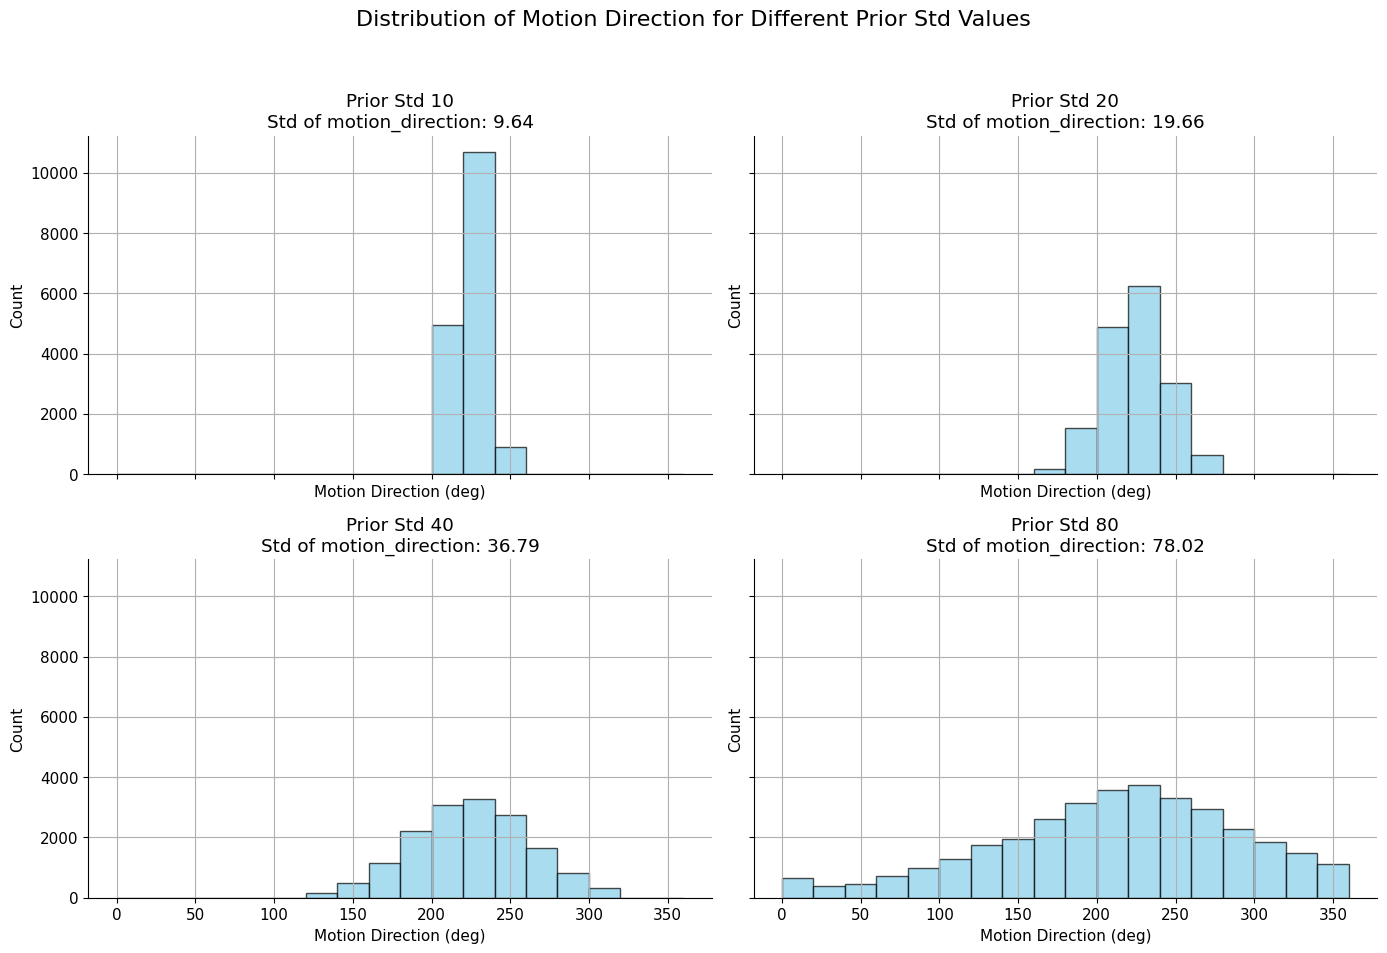

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assume 'data' DataFrame is available in the notebook

# Filter out trials with missing values in 'motion_direction', 'prior_std', and 'estimated_degree'
df = data.dropna(subset=['motion_direction', 'prior_std', 'estimated_degree'])

# Only consider the specified prior_std values
prior_stds_to_plot = [10, 20, 40, 80]

# Set up 2x2 subplots for the four prior_std values
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, prior_std in enumerate(prior_stds_to_plot):
    ax = axes[idx]
    subset = df[df['prior_std'] == prior_std]
    if subset.empty:
        ax.set_title(f'Prior Std {prior_std} (No Data)')
        ax.axis('off')
        continue
    # Plot histogram of motion_direction for this prior_std
    ax.hist(subset['motion_direction'], bins=np.arange(0, 361, 20), color='skyblue', edgecolor='k', alpha=0.7)
    # Calculate and display std of motion_direction
    std_motion = np.std(subset['motion_direction'])
    ax.set_title(f'Prior Std {prior_std}\nStd of motion_direction: {std_motion:.2f}')
    ax.set_xlabel('Motion Direction (deg)')
    ax.set_ylabel('Count')
    ax.grid(True)

plt.suptitle('Distribution of Motion Direction for Different Prior Std Values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Dataset loaded successfully. First 5 rows:
   trial_index  trial_time  response_arrow_start_angle  motion_direction  \
0            1    0.000000                         NaN               225   
1            2    2.730730                         NaN               225   
2            3    4.913950                         NaN               235   
3            4    6.997296                         NaN               225   
4            5    9.097130                         NaN               215   

   motion_coherence  estimate_x  estimate_y  reaction_time  raw_response_time  \
0              0.12   -1.749685   -1.785666            NaN                NaN   
1              0.12   -1.819693   -1.714269            NaN                NaN   
2              0.06   -1.562674   -1.951422            NaN                NaN   
3              0.06   -1.601388   -1.919781            NaN                NaN   
4              0.24   -1.639461   -1.887371            NaN                NaN   

   prior_std 

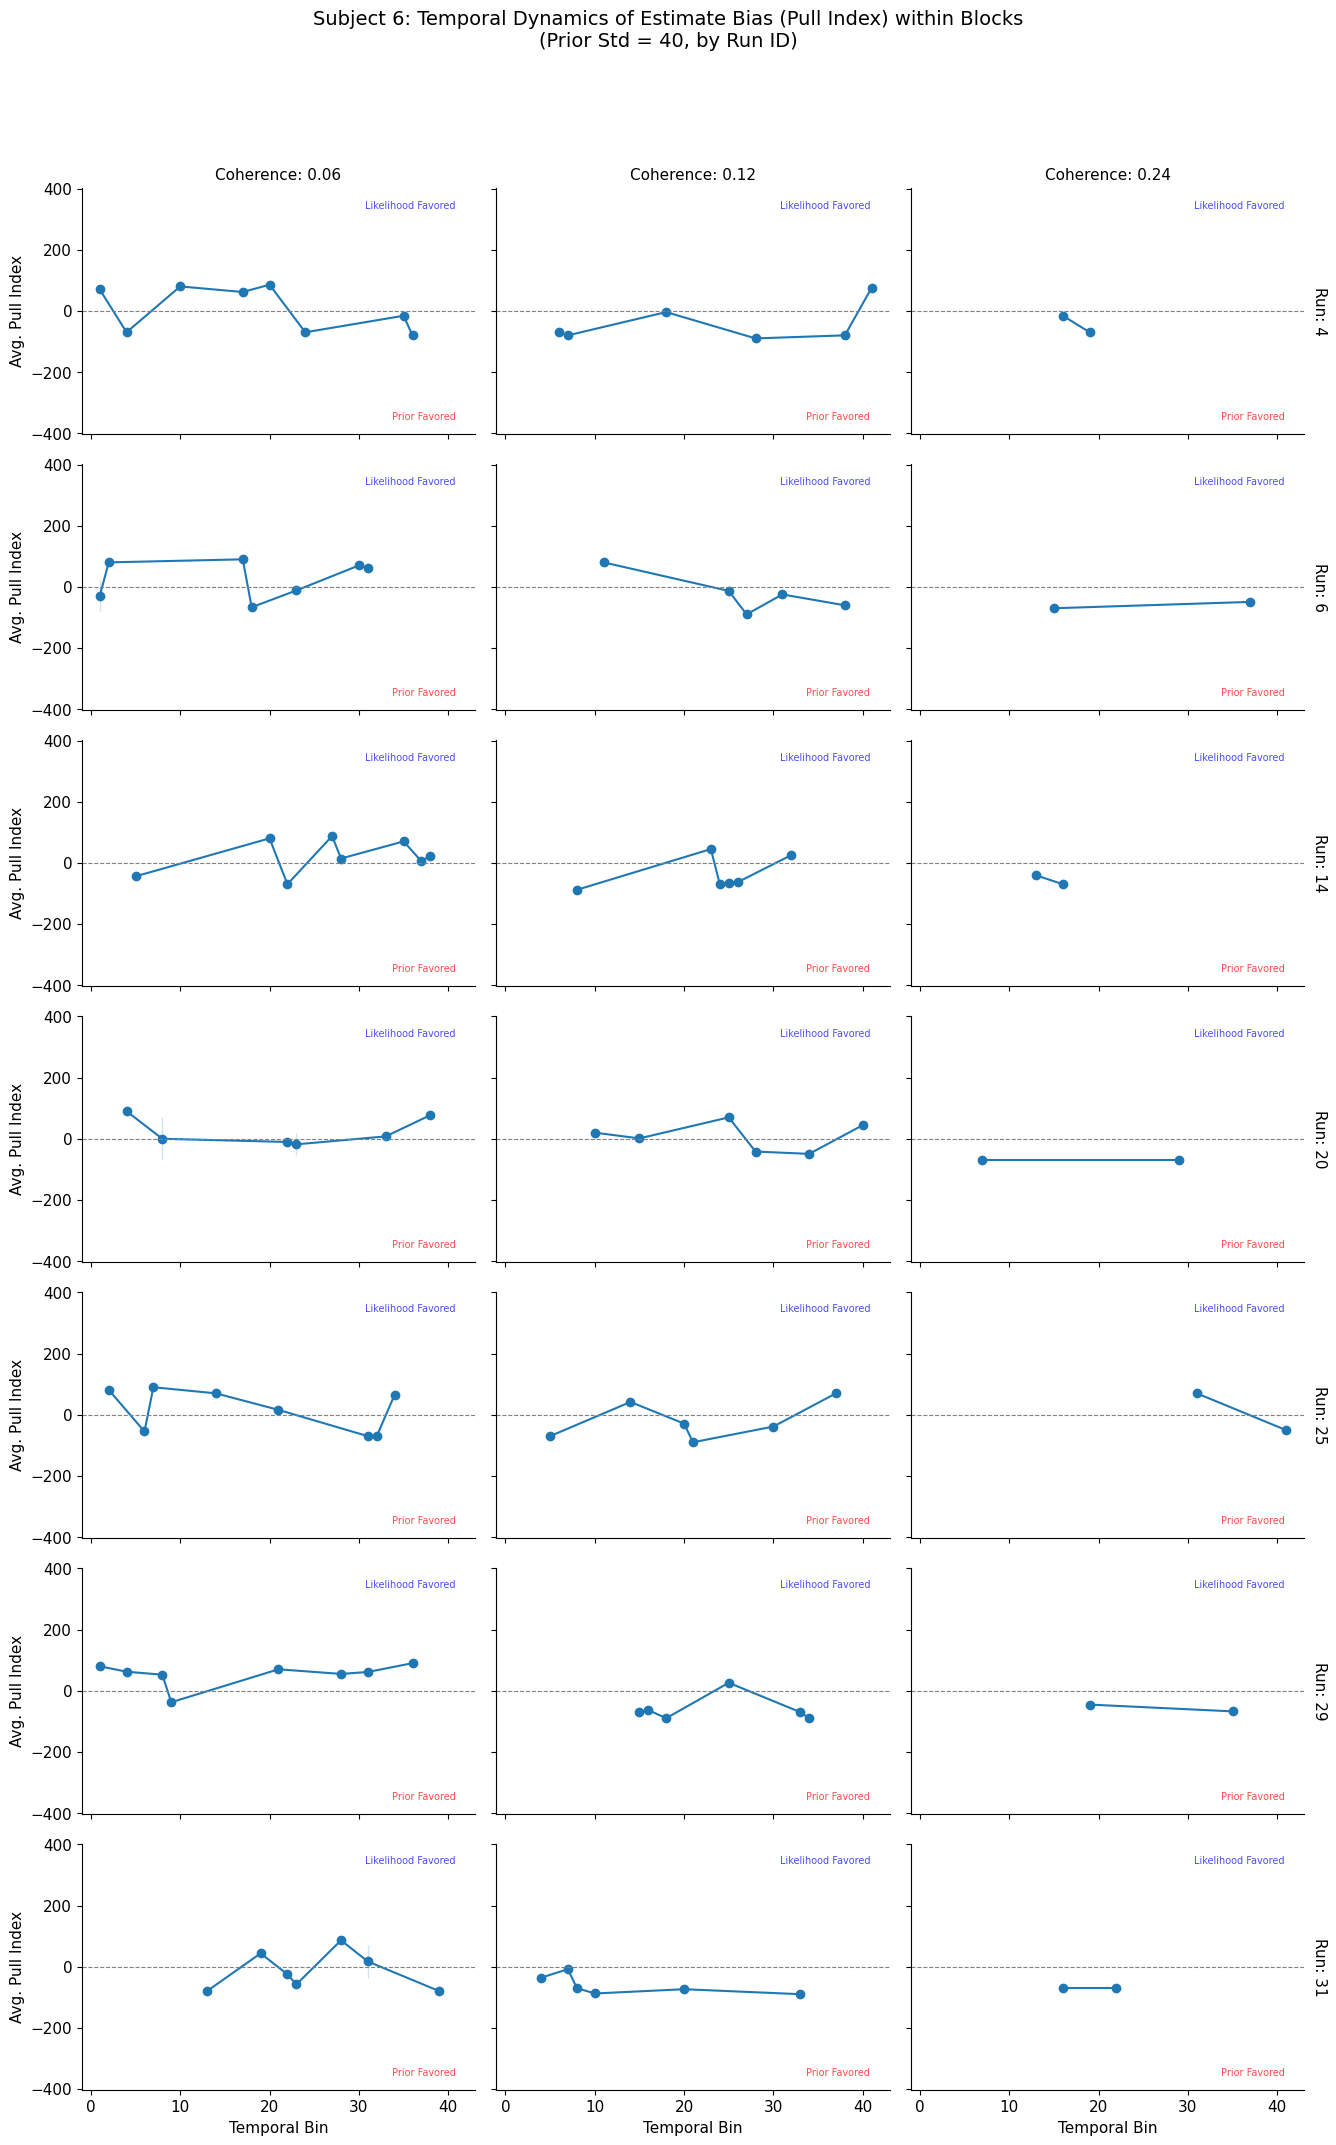

  'subject_6_pull_index_dynamics_stable_y_by_run_priorstd40.png' generated.

Generating plots for Subject ID: 10


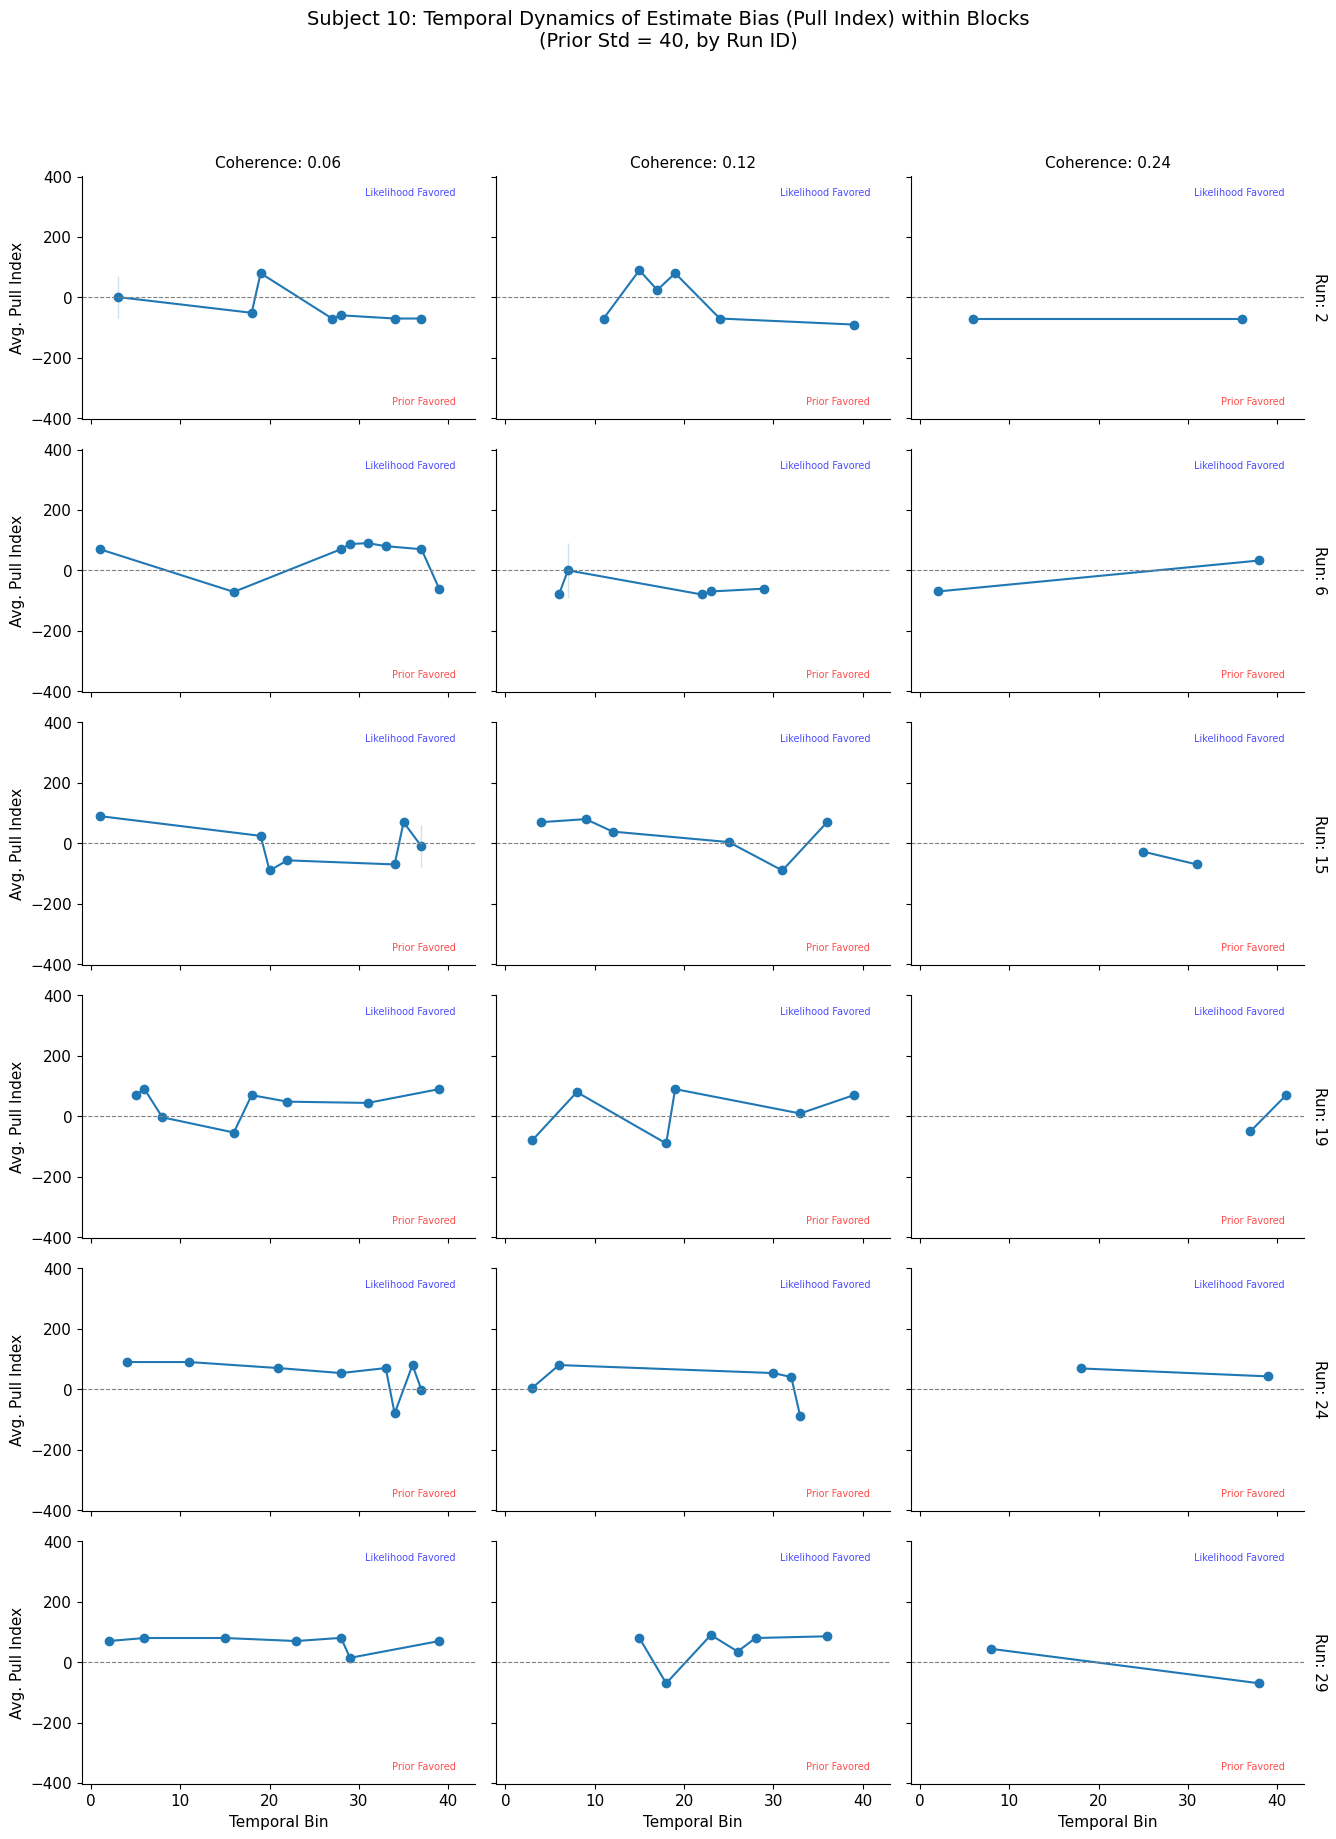

  'subject_10_pull_index_dynamics_stable_y_by_run_priorstd40.png' generated.

Generating plots for Subject ID: 11


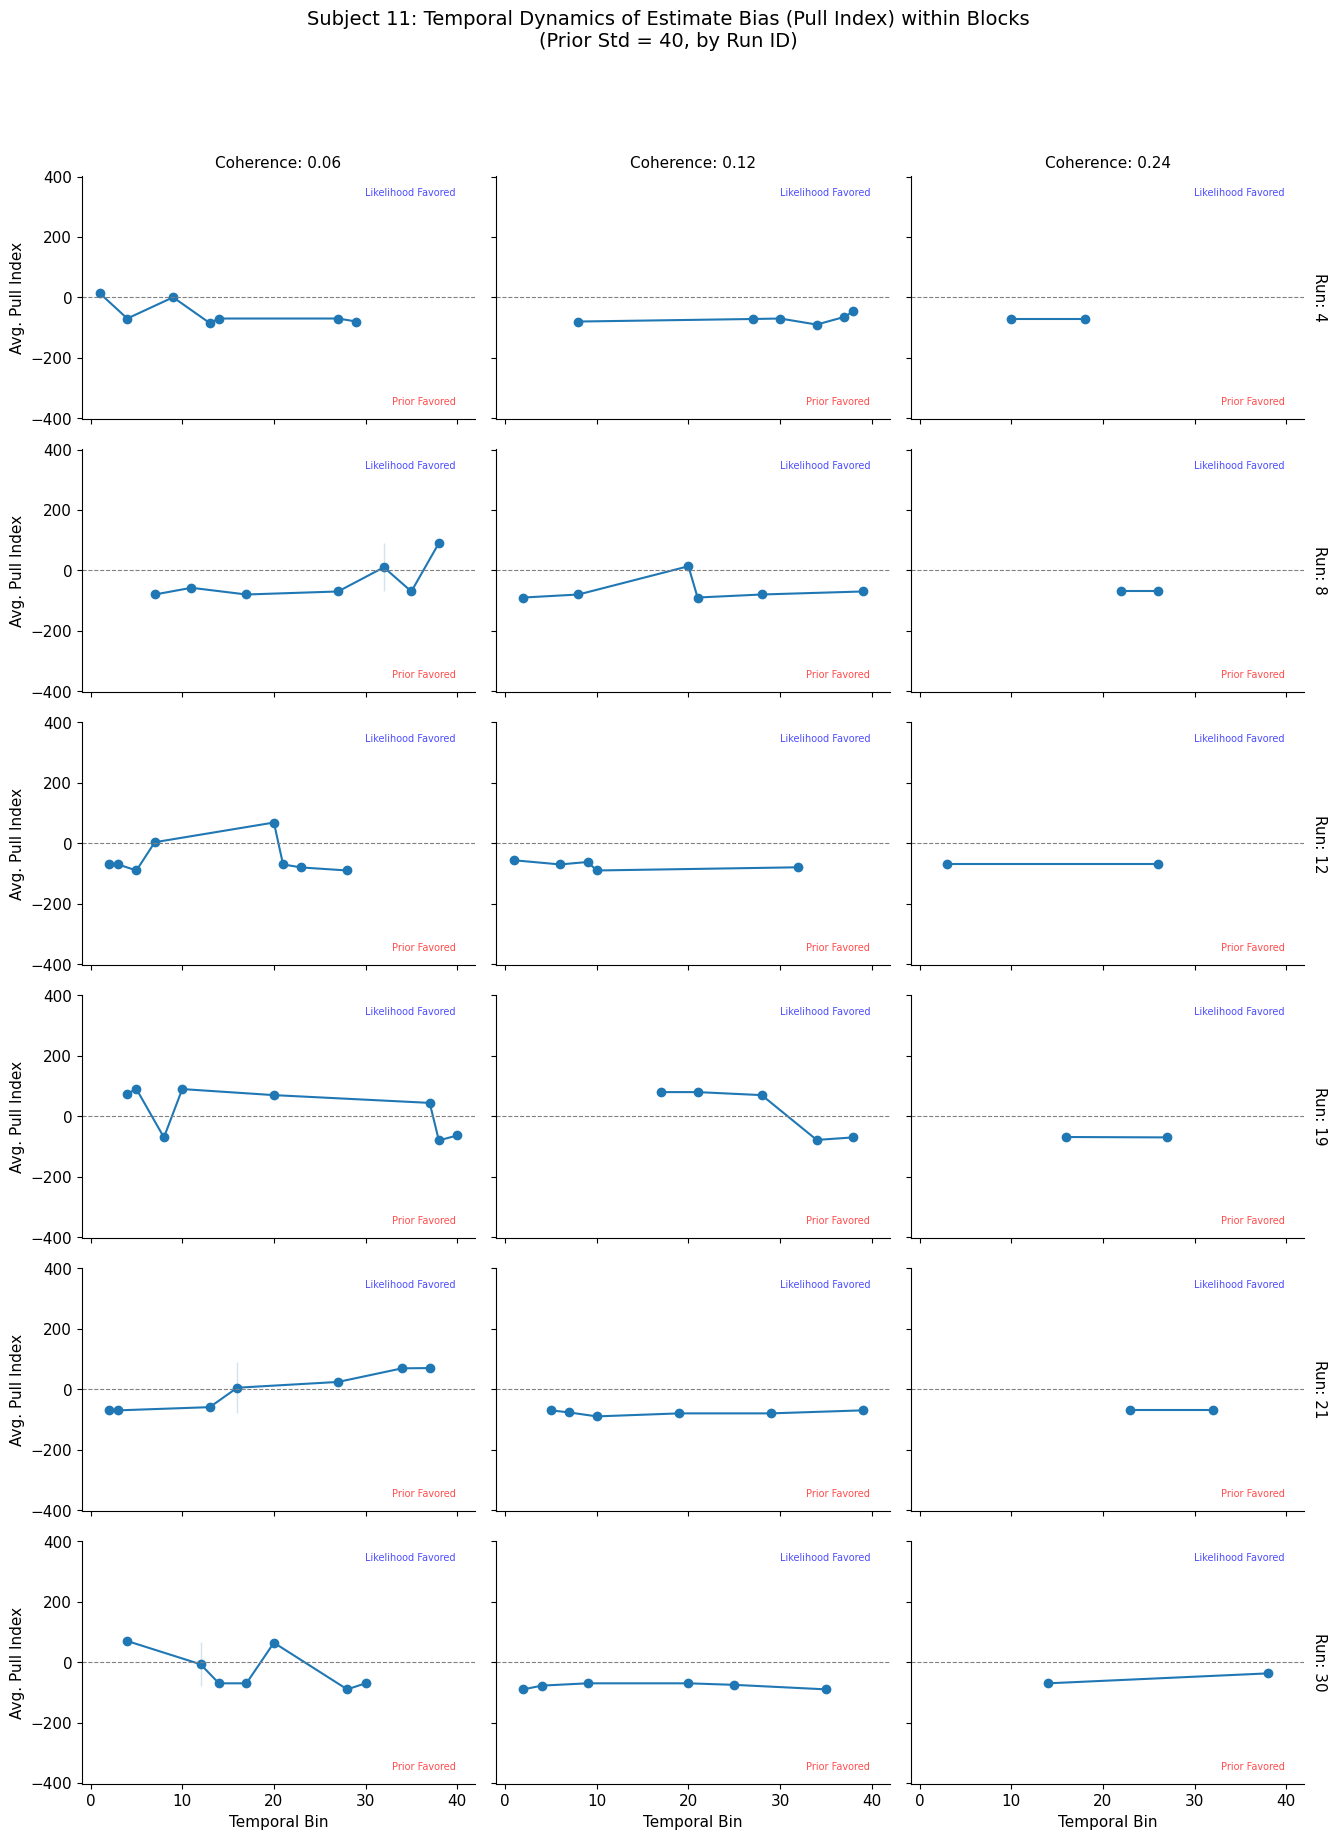

  'subject_11_pull_index_dynamics_stable_y_by_run_priorstd40.png' generated.

Generating plots for Subject ID: 8


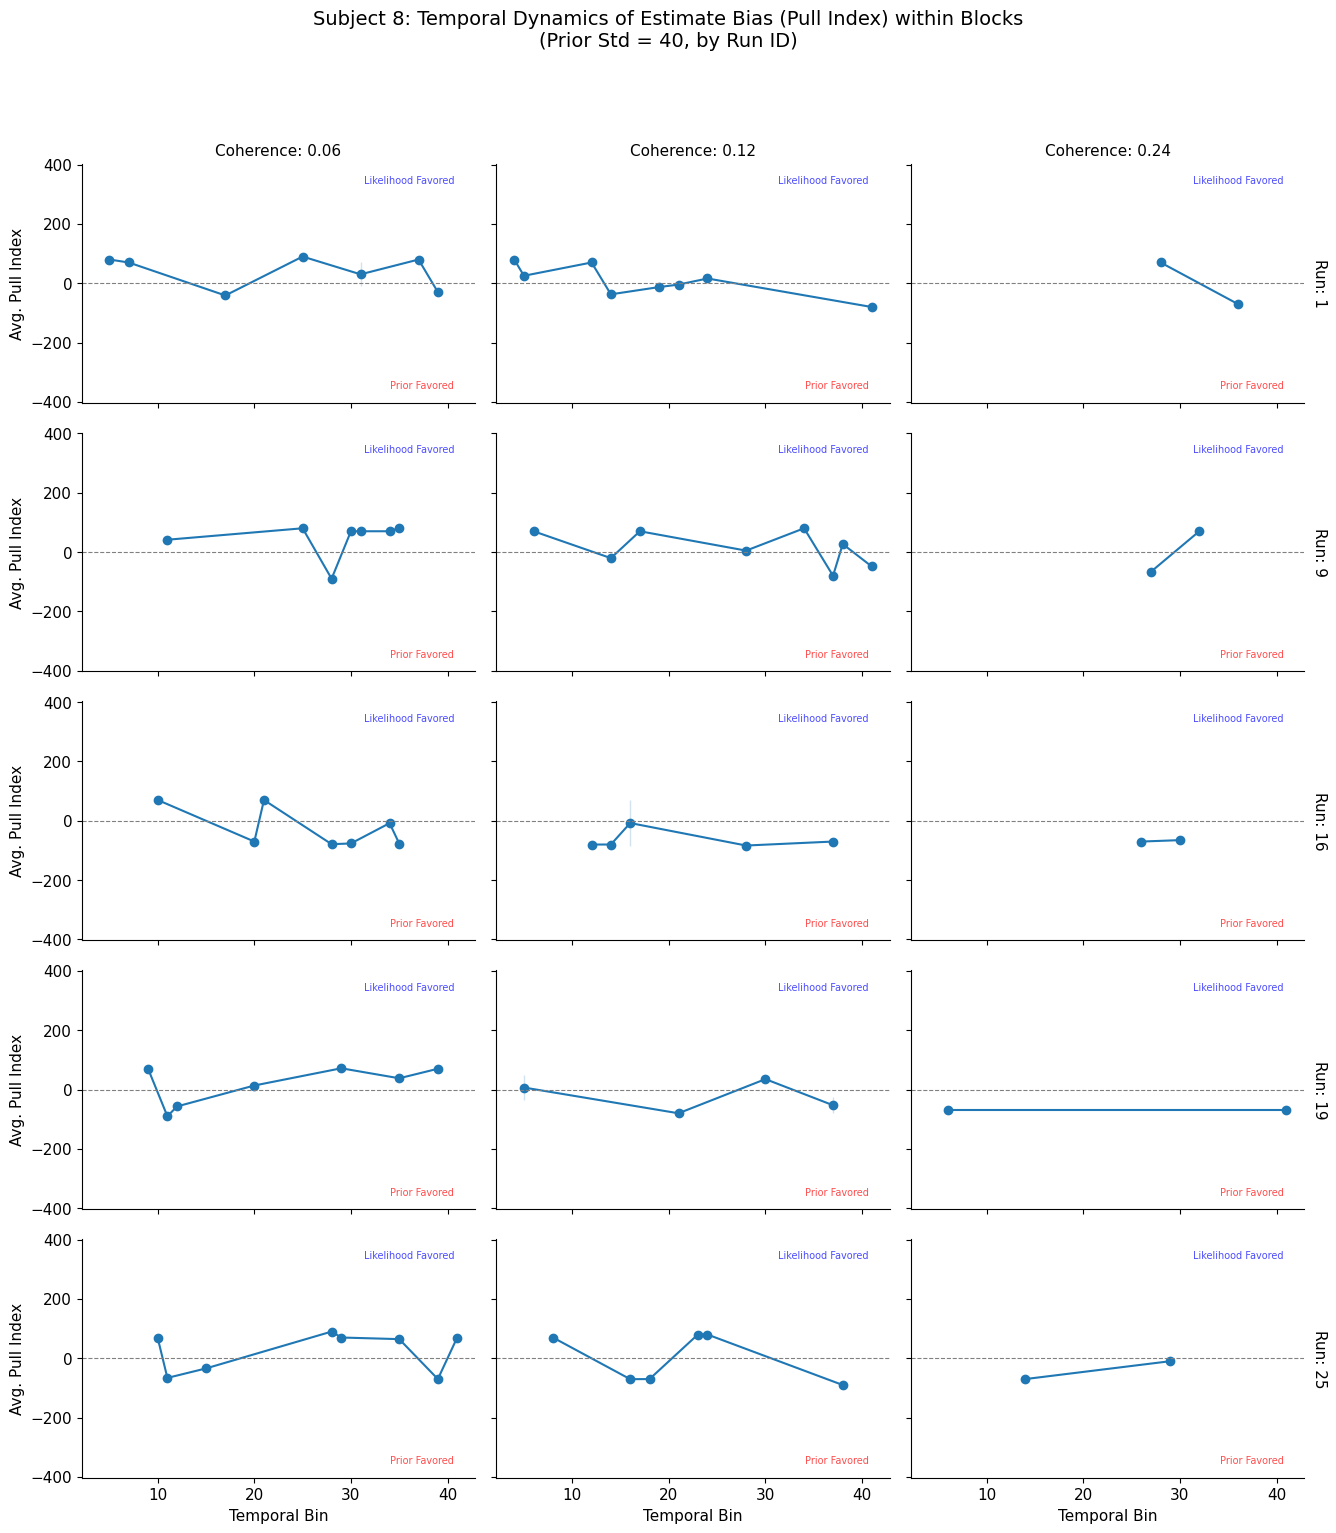

  'subject_8_pull_index_dynamics_stable_y_by_run_priorstd40.png' generated.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

GitURL = 'https://raw.githubusercontent.com/steevelaquitaine/projInference/refs/heads/gh-pages/data/csv/data01_direction4priors.csv'
df = pd.read_csv(GitURL)
print("Dataset loaded successfully. First 5 rows:")
print(df.head())

#Converting raw estimates to angular measures.
df['estimated_angle_radians'] = np.arctan2(df['estimate_y'],df['estimate_x'])
df['estimated_angle_degrees'] = np.rad2deg(df['estimated_angle_radians'])
df['estimated_angle_degrees'] = (df['estimated_angle_degrees'] + 360) % 360

print('Estimated angles calculated and adjusted to a 0-360 degree')
print(df[['estimate_x', 'estimate_y', 'estimated_angle_degrees']].head())
print("\n---")

def circular_difference(angle1, angle2):
    diff = (angle1 - angle2 + 180) % 360 - 180
    return diff

df['estimate_relative_to_prior_mean'] = df.apply(lambda row: circular_difference(row['estimated_angle_degrees'], row['prior_mean']), axis=1)
df['estimate_relative_to_true_direction'] = df.apply(lambda row: circular_difference(row['estimated_angle_degrees'], row['motion_direction']), axis=1)
df['true_prior_seperation'] = df.apply(lambda row: circular_difference(row['motion_direction'], row['prior_mean']), axis=1)
df['prior_likelihood_pull_index'] = np.abs(df['estimate_relative_to_true_direction']) - np.abs(df['estimate_relative_to_prior_mean'])

print("Error metrics calculated successfully. Sample rows:")
print(df[['motion_direction', 'prior_mean', 'estimated_angle_degrees',
          'estimate_relative_to_prior_mean', 'estimate_relative_to_true_direction',
          'true_prior_seperation', 'prior_likelihood_pull_index']].head())
print("\n---")

df['trial_in_block'] = df.groupby(['subject_id', 'session_id', 'run_id']).cumcount() + 1
bin_size = 5
df['temporal_bin'] = np.ceil(df['trial_in_block'] / bin_size).astype(int)

separation_threshold = 60
df_filtered = df[np.abs(df['true_prior_seperation']) > separation_threshold].copy()

print(f"Temporal bins and filtered dataset created (separation > {separation_threshold} degrees).")
print(df[['subject_id', 'session_id', 'run_id', 'trial_in_block', 'temporal_bin']].head())
print(f"\nNumber of trials in filtered dataset: {len(df_filtered)}")
print("\n---")

print("--- Starting Plot 1 Generation: Temporal Dynamics of Pull Index ---")

if df_filtered.empty:
    print("Filtered DataFrame (df_filtered) is empty. Cannot plot temporal dynamics of pull index.")
    print("This might happen if 'separation_threshold' in the previous code was too high or data is sparse.")
else:
    temporal_dynamics_summary = df_filtered.groupby(
        ['subject_id', 'prior_std', 'motion_coherence', 'temporal_bin']
    )['prior_likelihood_pull_index'].agg(['mean', 'sem']).reset_index()
    temporal_dynamics_summary.rename(columns={'mean': 'avg_pull_index', 'sem': 'sem_pull_index'}, inplace=True)

    overall_temporal_dynamics = temporal_dynamics_summary.groupby(
        ['prior_std', 'motion_coherence', 'temporal_bin']
    ).agg(
        avg_pull_index_overall=('avg_pull_index', 'mean'),
        sem_pull_index_overall=('avg_pull_index', 'sem')
    ).reset_index()

all_SubjectID = np.array(df['subject_id'].unique())
num_subjects_to_select = 4
randomly_selected_subjects = np.random.choice(all_SubjectID, num_subjects_to_select, replace=False)
print(f"Randomly selected {num_subjects_to_select} subjects for individual analysis:")
print(randomly_selected_subjects)

temporal_dynamics_summary_for_limits = df_filtered.groupby(
    ['subject_id', 'prior_std', 'motion_coherence', 'temporal_bin']
)['prior_likelihood_pull_index'].agg(['mean', 'sem']).reset_index()
temporal_dynamics_summary_for_limits.rename(columns={'mean': 'avg_pull_index', 'sem': 'sem_pull_index'}, inplace=True)

valid_pull_indices = temporal_dynamics_summary_for_limits['avg_pull_index'].dropna()
valid_sems = temporal_dynamics_summary_for_limits['sem_pull_index'].dropna()

global_y_min_val = valid_pull_indices.min() - (valid_sems.max() * 2 if not valid_sems.empty else 0)
global_y_max_val = valid_pull_indices.max() + (valid_sems.max() * 2 if not valid_sems.empty else 0)

plot_y_min = min(global_y_min_val, -abs(global_y_max_val)) - 5
plot_y_max = max(global_y_max_val, abs(global_y_min_val)) + 5

if plot_y_max - plot_y_min < 20:
    mid_point = (plot_y_min + plot_y_max) / 2
    plot_y_min = mid_point - 10
    plot_y_max = mid_point + 10

def plot_ind_error_robust(x, y, yerr, **kwargs):
    if not np.isnan(yerr).all():
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2, **kwargs)

# --- Loop through each randomly selected subject (Updated Section) ---
for sub_id in randomly_selected_subjects:
    print(f"\nGenerating plots for Subject ID: {sub_id}")

    subject_df = df[df['subject_id'] == sub_id].copy()
    subject_df_filtered = subject_df[np.abs(subject_df['true_prior_seperation']) > separation_threshold].copy()

    # Only keep rows with prior_std == 40
    subject_df_filtered = subject_df_filtered[subject_df_filtered['prior_std'] == 40].copy()

    if subject_df_filtered.empty:
        print(f"  No filtered data for Subject {sub_id} with prior_std=40. Skipping Pull Index plot.")
    else:
        # --- Group by run_id as well, but only for prior_std==40 ---
        individual_temporal_dynamics = subject_df_filtered.groupby(
            ['run_id', 'prior_std', 'motion_coherence', 'temporal_bin']
        )['prior_likelihood_pull_index'].agg(['mean', 'sem']).reset_index()
        individual_temporal_dynamics.rename(columns={'mean': 'avg_pull_index', 'sem': 'sem_pull_index'}, inplace=True)

        # Only plot if there is at least one run
        if individual_temporal_dynamics.empty:
            print(f"  No data to plot for Subject {sub_id} with prior_std=40 after grouping. Skipping.")
            continue

        g_ind_pull = sns.FacetGrid(
            individual_temporal_dynamics,
            row="run_id",
            col="motion_coherence",
            height=3, aspect=1.5, sharey=True,
            margin_titles=True
        )

        g_ind_pull.map(plt.plot, "temporal_bin", "avg_pull_index", marker='o')
        g_ind_pull.map(plot_ind_error_robust, "temporal_bin", "avg_pull_index", "sem_pull_index")

        g_ind_pull.set(ylim=(plot_y_min, plot_y_max))
        g_ind_pull.set_axis_labels("Temporal Bin", "Avg. Pull Index")
        g_ind_pull.set_titles(
            col_template="Coherence: {col_name}",
            row_template="Run: {row_name}"
        )
        g_ind_pull.fig.suptitle(
            f'Subject {sub_id}: Temporal Dynamics of Estimate Bias (Pull Index) within Blocks\n(Prior Std = 40, by Run ID)',
            y=1.02, fontsize=14
        )

        for ax in g_ind_pull.axes.flat:
            ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
            ax.text(ax.get_xlim()[1] * 0.95, plot_y_max * 0.9, 'Likelihood Favored',
                    horizontalalignment='right', verticalalignment='top', color='blue', fontsize=7, alpha=0.7)
            ax.text(ax.get_xlim()[1] * 0.95, plot_y_min * 0.9, 'Prior Favored',
                    horizontalalignment='right', verticalalignment='bottom', color='red', fontsize=7, alpha=0.7)

        plt.tight_layout(rect=(0, 0, 1, 0.98))
        plt.savefig(f'subject_{sub_id}_pull_index_dynamics_stable_y_by_run_priorstd40.png')
        plt.show()
        plt.close(g_ind_pull.fig)

        print(f"  'subject_{sub_id}_pull_index_dynamics_stable_y_by_run_priorstd40.png' generated.")


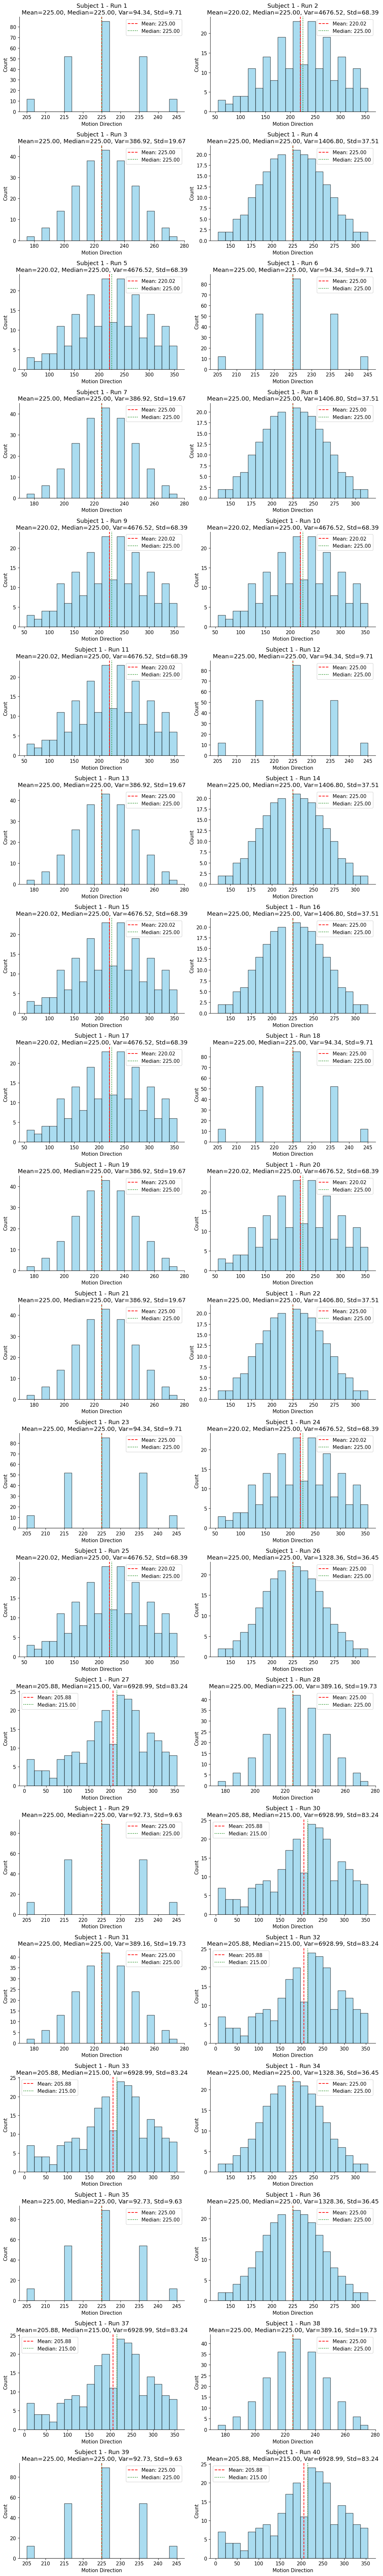

In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

# Assume df is your main DataFrame containing all data

def plot_motion_direction_histograms(subject_id):
    clear_output(wait=True)
    subject_df = df[df['subject_id'] == subject_id]
    run_ids = sorted(subject_df['run_id'].unique())
    n_runs = len(run_ids)
    ncols = 2
    nrows = int(np.ceil(n_runs / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
    axes = axes.flatten() if n_runs > 1 else [axes]
    
    for i, run_id in enumerate(run_ids):
        ax = axes[i]
        run_df = subject_df[subject_df['run_id'] == run_id]
        data = run_df['motion_direction'].dropna()
        ax.hist(data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        mean = data.mean()
        median = data.median()
        var = data.var()
        std = data.std()
        ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
        ax.axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}')
        ax.set_title(f'Subject {subject_id} - Run {run_id}\nMean={mean:.2f}, Median={median:.2f}, Var={var:.2f}, Std={std:.2f}')
        ax.set_xlabel('Motion Direction')
        ax.set_ylabel('Count')
        ax.legend()
    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

subject_ids = sorted(df['subject_id'].unique())
subject_selector = widgets.Dropdown(
    options=subject_ids,
    description='Subject ID:',
    value=subject_ids[0]
)

def on_subject_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        plot_motion_direction_histograms(change['new'])

subject_selector.observe(on_subject_change)
display(subject_selector)
plot_motion_direction_histograms(subject_selector.value)


In [15]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

# Helper function for circular difference
def circular_diff(angle1, angle2):
    diff = np.abs(angle1 - angle2) % 360
    return np.minimum(diff, 360 - diff)

# Widget for subject selection
subject_ids = sorted(df['subject_id'].unique())
subject_widget = widgets.Dropdown(
    options=subject_ids,
    description='Subject:',
    value=subject_ids[0]
)

# Widget for std selection
stds = sorted(df['prior_std'].dropna().unique())
std_widget = widgets.Dropdown(
    options=stds,
    description='Prior Std:',
    value=stds[0]
)

# Widget for run selection (will be updated dynamically)
def get_run_options(subject, std):
    return sorted(df[(df['subject_id'] == subject) & (df['prior_std'] == std)]['run_id'].unique())

run_widget = widgets.SelectMultiple(
    options=get_run_options(subject_widget.value, std_widget.value),
    description='Runs:',
    value=tuple(get_run_options(subject_widget.value, std_widget.value))
)

# Widget for motion coherence selection (3 values)
def get_coherence_options(subject, std, runs):
    mask = (
        (df['subject_id'] == subject) &
        (df['prior_std'] == std) &
        (df['run_id'].isin(runs))
    )
    return sorted(df[mask]['motion_coherence'].dropna().unique())

coherence_widget = widgets.SelectMultiple(
    options=get_coherence_options(subject_widget.value, std_widget.value, run_widget.value)[:3],
    description='Coherence:',
    value=tuple(get_coherence_options(subject_widget.value, std_widget.value, run_widget.value)[:3])
)

# Widget for minimum absolute circular difference from 225
min_circ_diff_widget = widgets.FloatSlider(
    value=0,
    min=0,
    max=180,
    step=1,
    description='Min |Δ225|:',
    continuous_update=False
)

# Update run options when subject or std changes
def update_run_options(*args):
    runs = get_run_options(subject_widget.value, std_widget.value)
    run_widget.options = runs
    run_widget.value = tuple(runs)
    update_coherence_options()

def update_coherence_options(*args):
    coherences = get_coherence_options(subject_widget.value, std_widget.value, run_widget.value)
    # Only allow up to 3
    coherence_widget.options = coherences
    coherence_widget.value = tuple(coherences[:3])

subject_widget.observe(update_run_options, names='value')
std_widget.observe(update_run_options, names='value')
run_widget.observe(update_coherence_options, names='value')

# Plotting function
def plot_histogram(subject, std, runs, coherences, min_circ_diff):
    clear_output(wait=True)
    display(ui)
    # Filter dataframe
    mask = (
        (df['subject_id'] == subject) &
        (df['prior_std'] == std) &
        (df['run_id'].isin(runs)) &
        (df['motion_coherence'].isin(coherences))
    )
    filtered = df[mask].copy()
    # Compute circular difference from 225
    filtered['circ_diff_225'] = circular_diff(filtered['motion_direction'], 225)
    filtered = filtered[filtered['circ_diff_225'] >= min_circ_diff]

    print(filtered.head())
    # Compute mean of estimated_degree and mean of motion_direction
    if 'estimated_degree' not in filtered.columns:
        print("No 'estimated_degree' column found in data.")
        return
    if filtered.empty:
        print("No data for selected filters.")
        return
    mean_estimated = filtered['estimated_degree'].mean()
    mean_motion = filtered['motion_direction'].mean()
    mean_diff = circular_diff(mean_motion, mean_estimated)
    # Plot histogram of (estimated_degree - 225)
    plt.figure(figsize=(8,5))
    diffs = circular_diff(filtered['estimated_degree'], 225)
    plt.hist(diffs, bins=20, color='orange', edgecolor='black', alpha=0.7)
    plt.axvline(diffs.mean(), color='red', linestyle='--', label=f'Mean diff: {diffs.mean():.2f}')
    plt.title(f'Subject {subject}, Std {std}, Runs {runs}\n'
              f'Coherence {coherences}, Min |Δ225|={min_circ_diff}\n'
              f'Mean(estimated-225)={diffs.mean():.2f}')
    plt.xlabel('Absolute Circular Difference from 225 (deg)')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Interactive UI
ui = widgets.VBox([
    widgets.HBox([subject_widget, std_widget, run_widget]),
    widgets.HBox([coherence_widget, min_circ_diff_widget])
])

out = widgets.interactive_output(
    plot_histogram,
    {
        'subject': subject_widget,
        'std': std_widget,
        'runs': run_widget,
        'coherences': coherence_widget,
        'min_circ_diff': min_circ_diff_widget
    }
)

display(ui, out)


Output()